<a href="https://colab.research.google.com/github/gaesu96/gaesu_public/blob/main/warship_Detection_fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# mmdetection install

import torch

# 작업환경이 mmdetection 2.x 기준으로, pytorch 1.13.0으로 setting(mmdetection 2.x는 pytorch 2.0대를 지원하지 않음)
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
# mmcv를 위해서 mmcv-full을 먼저 설치
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
# mmdetection은 3.0 version이 출시되었으나, 실습 환경 상 2.x대로 설치
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 518.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.13.0+cu116 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.13.0+cu116 which is incompatible.
torchtext 0.17.1 requires torc

Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 6.3 MB/s eta 0:00:00
Cloning into 'mmdetection'...
remote: Enumerating objects: 38019, done.
remote: Total 38019 (delta 0), reused 0 (delta 0), pack-reused 38019
Receiving objects: 100% (38019/38019), 63.25 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (26222/26222), done.
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        *

In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [33]:
# self data_root, ann_file, img_prefix 활용
import copy
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
import mmcv
import cv2
import numpy as np
import os.path as osp

@DATASETS.register_module(force=True)
class WarshipDataset(CustomDataset):
  CLASSES = ('DDG', 'DDH', 'FFG', 'FF', 'PCC', 'PKG', 'LST', 'MLS', 'AOE', 'ATS', 'HULL_NUM')

  def load_annotations(self, ann_file):
    print('self.data_root', self.data_root, 'self.ann_file:', ann_file, 'self.img_prefix:')
    cat2label = {k:int(i) for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)

    data_infos = []

    for image_id in image_list:
      filename = '{0:}/{1:}.jpg'.format(self.img_prefix, image_id)
      image = cv2.imread(filename)
      height, width = image.shape[:2]

      data_info = {'filename': str(image_id) + '.jpg',
                   'width': width, 'height': height}

      label_prefix = self.img_prefix.replace('image', 'label')
      lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

      content = [line.strip().split(' ') for line in lines]

      bbox_idxes = [x[0] for x in content]
      bboxes = [[float(info) for info in x[1:]] for x in content]

      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      for bbox_idx, bbox in zip(bbox_idxes, bboxes):
        left = (bbox[0] - (bbox[2] / 2)) * width
        top = (bbox[1] - (bbox[3] / 2)) * height
        right = (bbox[0] + (bbox[2] / 2)) * width
        bottom = (bbox[1] + (bbox[3] / 2)) * height

        bbox[0] = left
        bbox[1] = top
        bbox[2] = right
        bbox[3] = bottom
        if int(bbox_idx) in cat2label.values():
          gt_bboxes.append(bbox)
          gt_labels.append(bbox_idx)

        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)

      data_anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
          'labels': np.array(gt_labels, dtype=np.int64),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.int64)
      }

      data_info.update(ann=data_anno)
      data_infos.append(data_info)
    return data_infos


In [3]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [6]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2024-05-09 10:31:20--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.20.179, 47.246.20.180, 47.246.20.181, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.20.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  12.8MB/s    in 13s     

2024-05-09 10:31:33 (12.4 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [34]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [69]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'WarshipDataset'
cfg.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'

cfg.data.train.type = 'WarshipDataset'
cfg.data.train.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image'

cfg.data.val.type = 'WarshipDataset'
cfg.data.val.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image'

cfg.data.test.type = 'WarshipDataset'
cfg.data.test.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image'

cfg.model.roi_head.bbox_head.num_classes = 11

cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg.work_dir = '/content/drive/MyDrive/warship_detect_project/tutorial_exps_normal'
cfg.optimizer = dict(type='SGD', lr=0.02 / 8, momentum = 0.9, weight_decay=0.0001)

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.lr_config.policy = 'step'

cfg.evaluation.metric = 'mAP'

cfg.evaluation.interval = 1

cfg.checkpoint_config.interval = 12

cfg.seed = 0

cfg.runner.max_epochs = 100

set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [70]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets = [build_dataset(cfg.data.train)]

self.data_root /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/ self.ann_file: /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/train.txt self.img_prefix:


In [63]:
datasets

[
 WarshipDataset Train dataset with number of images 849, and instance counts: 
 +---------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
 | category      | count | category | count | category | count | category | count | category | count |
 +---------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
 | 0 [DDG]       | 76    | 1 [DDH]  | 104   | 2 [FFG]  | 82    | 3 [FF]   | 97    | 4 [PCC]  | 111   |
 | 5 [PKG]       | 105   | 6 [LST]  | 102   | 7 [MLS]  | 68    | 8 [AOE]  | 93    | 9 [ATS]  | 55    |
 |               |       |          |       |          |       |          |       |          |       |
 | 10 [HULL_NUM] | 894   |          |       |          |       |          |       |          |       |
 +---------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+]

In [71]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

In [72]:
%cd mmdetection

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2024-05-09 15:07:17,180 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection
self.data_root /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/ self.ann_file: /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/val.txt self.img_prefix:


2024-05-09 15:07:18,437 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2024-05-09 15:07:18,594 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([12]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([44, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([44]).
2024-05-09 15:07:18,602 - mmdet - INFO - Start running, host: root@f143815bea28, work_dir: /content/

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 7.9 task/s, elapsed: 12s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:10:28,396 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 115  | 0.857  | 0.104 |
| DDH      | 16  | 113  | 1.000  | 0.284 |
| FFG      | 10  | 128  | 1.000  | 0.169 |
| FF       | 13  | 89   | 0.846  | 0.229 |
| PCC      | 11  | 113  | 1.000  | 0.181 |
| PKG      | 14  | 108  | 1.000  | 0.274 |
| LST      | 10  | 117  | 1.000  | 0.130 |
| MLS      | 4   | 110  | 1.000  | 0.052 |
| AOE      | 11  | 110  | 1.000  | 0.294 |
| ATS      | 2   | 79   | 1.000  | 0.298 |
| HULL_NUM | 98  | 256  | 0.980  | 0.960 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.270 |
+----------+-----+------+--------+-------+
2024-05-09 15:10:28,401 - mmdet - INFO - Epoch(val) [1][95]	AP50: 0.2700, mAP: 0.2704
2024-05-09 15:10:35,306 - mmdet - INFO - Epoch [2][10/425]	lr: 2.500e-03, eta: 4:51:53, time: 0.668, data_time: 0.260, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.3 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:13:37,980 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 97   | 0.857  | 0.117 |
| DDH      | 16  | 112  | 1.000  | 0.257 |
| FFG      | 10  | 105  | 1.000  | 0.201 |
| FF       | 13  | 111  | 1.000  | 0.330 |
| PCC      | 11  | 112  | 1.000  | 0.206 |
| PKG      | 14  | 108  | 1.000  | 0.294 |
| LST      | 10  | 106  | 1.000  | 0.257 |
| MLS      | 4   | 100  | 1.000  | 0.145 |
| AOE      | 11  | 104  | 1.000  | 0.455 |
| ATS      | 2   | 36   | 0.500  | 0.250 |
| HULL_NUM | 98  | 269  | 0.980  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.316 |
+----------+-----+------+--------+-------+
2024-05-09 15:13:38,142 - mmdet - INFO - Epoch(val) [2][95]	AP50: 0.3160, mAP: 0.3159
2024-05-09 15:13:44,761 - mmdet - INFO - Epoch [3][10/425]	lr: 2.500e-03, eta: 4:48:26, time: 0.649, data_time: 0.254, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:16:46,146 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 118  | 0.857  | 0.118 |
| DDH      | 16  | 117  | 1.000  | 0.173 |
| FFG      | 10  | 117  | 1.000  | 0.266 |
| FF       | 13  | 111  | 1.000  | 0.267 |
| PCC      | 11  | 126  | 1.000  | 0.198 |
| PKG      | 14  | 110  | 1.000  | 0.536 |
| LST      | 10  | 107  | 1.000  | 0.202 |
| MLS      | 4   | 90   | 1.000  | 0.065 |
| AOE      | 11  | 107  | 1.000  | 0.347 |
| ATS      | 2   | 39   | 0.500  | 0.250 |
| HULL_NUM | 98  | 224  | 0.980  | 0.972 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.308 |
+----------+-----+------+--------+-------+
2024-05-09 15:16:46,306 - mmdet - INFO - Epoch(val) [3][95]	AP50: 0.3080, mAP: 0.3084
2024-05-09 15:16:52,745 - mmdet - INFO - Epoch [4][10/425]	lr: 2.500e-03, eta: 4:44:31, time: 0.631, data_time: 0.239, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.6 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:19:52,135 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 99   | 0.857  | 0.227 |
| DDH      | 16  | 108  | 1.000  | 0.184 |
| FFG      | 10  | 107  | 1.000  | 0.179 |
| FF       | 13  | 113  | 1.000  | 0.454 |
| PCC      | 11  | 118  | 1.000  | 0.219 |
| PKG      | 14  | 106  | 1.000  | 0.579 |
| LST      | 10  | 103  | 1.000  | 0.290 |
| MLS      | 4   | 98   | 1.000  | 0.056 |
| AOE      | 11  | 103  | 1.000  | 0.605 |
| ATS      | 2   | 113  | 1.000  | 0.280 |
| HULL_NUM | 98  | 169  | 0.990  | 0.977 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.368 |
+----------+-----+------+--------+-------+
2024-05-09 15:19:52,308 - mmdet - INFO - Epoch(val) [4][95]	AP50: 0.3680, mAP: 0.3681
2024-05-09 15:19:59,152 - mmdet - INFO - Epoch [5][10/425]	lr: 2.500e-03, eta: 4:41:01, time: 0.672, data_time: 0.270, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.4 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:22:59,828 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 83   | 1.000  | 0.341 |
| DDH      | 16  | 101  | 1.000  | 0.322 |
| FFG      | 10  | 90   | 1.000  | 0.236 |
| FF       | 13  | 89   | 1.000  | 0.618 |
| PCC      | 11  | 96   | 1.000  | 0.473 |
| PKG      | 14  | 100  | 1.000  | 0.820 |
| LST      | 10  | 101  | 1.000  | 0.302 |
| MLS      | 4   | 99   | 1.000  | 0.156 |
| AOE      | 11  | 95   | 1.000  | 0.821 |
| ATS      | 2   | 83   | 1.000  | 0.290 |
| HULL_NUM | 98  | 141  | 0.969  | 0.956 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.485 |
+----------+-----+------+--------+-------+
2024-05-09 15:22:59,994 - mmdet - INFO - Epoch(val) [5][95]	AP50: 0.4850, mAP: 0.4850
2024-05-09 15:23:06,452 - mmdet - INFO - Epoch [6][10/425]	lr: 2.500e-03, eta: 4:37:38, time: 0.633, data_time: 0.240, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.0 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:26:08,527 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 71   | 0.857  | 0.539 |
| DDH      | 16  | 88   | 1.000  | 0.613 |
| FFG      | 10  | 86   | 1.000  | 0.433 |
| FF       | 13  | 84   | 1.000  | 0.814 |
| PCC      | 11  | 65   | 1.000  | 0.725 |
| PKG      | 14  | 60   | 1.000  | 0.946 |
| LST      | 10  | 60   | 1.000  | 0.545 |
| MLS      | 4   | 87   | 1.000  | 0.430 |
| AOE      | 11  | 46   | 1.000  | 0.961 |
| ATS      | 2   | 70   | 1.000  | 1.000 |
| HULL_NUM | 98  | 134  | 0.980  | 0.972 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.725 |
+----------+-----+------+--------+-------+
2024-05-09 15:26:08,694 - mmdet - INFO - Epoch(val) [6][95]	AP50: 0.7250, mAP: 0.7253
2024-05-09 15:26:15,125 - mmdet - INFO - Epoch [7][10/425]	lr: 2.500e-03, eta: 4:34:41, time: 0.630, data_time: 0.239, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:29:16,101 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 19   | 0.857  | 0.740 |
| DDH      | 16  | 55   | 0.938  | 0.482 |
| FFG      | 10  | 54   | 0.900  | 0.343 |
| FF       | 13  | 63   | 1.000  | 0.837 |
| PCC      | 11  | 71   | 1.000  | 0.728 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 74   | 1.000  | 0.685 |
| MLS      | 4   | 57   | 1.000  | 0.625 |
| AOE      | 11  | 61   | 1.000  | 1.000 |
| ATS      | 2   | 67   | 1.000  | 1.000 |
| HULL_NUM | 98  | 136  | 0.980  | 0.969 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.758 |
+----------+-----+------+--------+-------+
2024-05-09 15:29:16,260 - mmdet - INFO - Epoch(val) [7][95]	AP50: 0.7580, mAP: 0.7580
2024-05-09 15:29:22,829 - mmdet - INFO - Epoch [8][10/425]	lr: 2.500e-03, eta: 4:31:40, time: 0.644, data_time: 0.245, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.5 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:32:24,429 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 49   | 1.000  | 0.752 |
| DDH      | 16  | 73   | 1.000  | 0.771 |
| FFG      | 10  | 72   | 1.000  | 0.479 |
| FF       | 13  | 29   | 1.000  | 0.841 |
| PCC      | 11  | 33   | 1.000  | 0.769 |
| PKG      | 14  | 19   | 0.929  | 0.929 |
| LST      | 10  | 74   | 1.000  | 0.911 |
| MLS      | 4   | 62   | 1.000  | 0.375 |
| AOE      | 11  | 55   | 1.000  | 0.939 |
| ATS      | 2   | 44   | 1.000  | 1.000 |
| HULL_NUM | 98  | 113  | 0.980  | 0.973 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.795 |
+----------+-----+------+--------+-------+
2024-05-09 15:32:24,756 - mmdet - INFO - Epoch(val) [8][95]	AP50: 0.7950, mAP: 0.7946
2024-05-09 15:32:31,264 - mmdet - INFO - Epoch [9][10/425]	lr: 2.500e-04, eta: 4:28:53, time: 0.637, data_time: 0.244, memory: 4658, loss_rpn

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.5 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:35:33,086 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 43   | 1.000  | 0.806 |
| DDH      | 16  | 62   | 1.000  | 0.822 |
| FFG      | 10  | 61   | 1.000  | 0.541 |
| FF       | 13  | 35   | 1.000  | 0.847 |
| PCC      | 11  | 42   | 1.000  | 0.849 |
| PKG      | 14  | 35   | 1.000  | 0.959 |
| LST      | 10  | 56   | 1.000  | 0.900 |
| MLS      | 4   | 53   | 1.000  | 0.861 |
| AOE      | 11  | 50   | 1.000  | 1.000 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 110  | 0.969  | 0.961 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.868 |
+----------+-----+------+--------+-------+
2024-05-09 15:35:33,379 - mmdet - INFO - Epoch(val) [9][95]	AP50: 0.8680, mAP: 0.8679
2024-05-09 15:35:39,797 - mmdet - INFO - Epoch [10][10/425]	lr: 2.500e-04, eta: 4:25:57, time: 0.628, data_time: 0.237, memory: 4658, loss_rp

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:38:41,476 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 43   | 1.000  | 0.802 |
| DDH      | 16  | 64   | 1.000  | 0.817 |
| FFG      | 10  | 61   | 1.000  | 0.538 |
| FF       | 13  | 35   | 1.000  | 0.881 |
| PCC      | 11  | 44   | 1.000  | 0.825 |
| PKG      | 14  | 31   | 0.929  | 0.929 |
| LST      | 10  | 57   | 1.000  | 0.908 |
| MLS      | 4   | 54   | 1.000  | 0.788 |
| AOE      | 11  | 36   | 1.000  | 1.000 |
| ATS      | 2   | 34   | 1.000  | 1.000 |
| HULL_NUM | 98  | 108  | 0.980  | 0.973 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.860 |
+----------+-----+------+--------+-------+
2024-05-09 15:38:41,653 - mmdet - INFO - Epoch(val) [10][95]	AP50: 0.8600, mAP: 0.8599
2024-05-09 15:38:48,072 - mmdet - INFO - Epoch [11][10/425]	lr: 2.500e-04, eta: 4:22:58, time: 0.629, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.5 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:41:48,728 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 42   | 1.000  | 0.836 |
| DDH      | 16  | 57   | 1.000  | 0.814 |
| FFG      | 10  | 55   | 1.000  | 0.683 |
| FF       | 13  | 36   | 1.000  | 0.887 |
| PCC      | 11  | 38   | 1.000  | 0.842 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 58   | 1.000  | 0.942 |
| MLS      | 4   | 58   | 1.000  | 0.736 |
| AOE      | 11  | 39   | 1.000  | 0.939 |
| ATS      | 2   | 35   | 1.000  | 1.000 |
| HULL_NUM | 98  | 109  | 0.990  | 0.983 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.872 |
+----------+-----+------+--------+-------+
2024-05-09 15:41:48,895 - mmdet - INFO - Epoch(val) [11][95]	AP50: 0.8720, mAP: 0.8718
2024-05-09 15:41:55,700 - mmdet - INFO - Epoch [12][10/425]	lr: 2.500e-05, eta: 4:20:05, time: 0.668, data_time: 0.262, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.6 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:44:59,537 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 43   | 1.000  | 0.856 |
| DDH      | 16  | 62   | 1.000  | 0.828 |
| FFG      | 10  | 59   | 1.000  | 0.602 |
| FF       | 13  | 38   | 1.000  | 0.908 |
| PCC      | 11  | 39   | 1.000  | 0.857 |
| PKG      | 14  | 27   | 0.929  | 0.929 |
| LST      | 10  | 55   | 1.000  | 0.917 |
| MLS      | 4   | 55   | 1.000  | 0.764 |
| AOE      | 11  | 39   | 1.000  | 0.962 |
| ATS      | 2   | 33   | 1.000  | 1.000 |
| HULL_NUM | 98  | 106  | 0.980  | 0.973 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.872 |
+----------+-----+------+--------+-------+
2024-05-09 15:44:59,729 - mmdet - INFO - Epoch(val) [12][95]	AP50: 0.8720, mAP: 0.8725
2024-05-09 15:45:06,166 - mmdet - INFO - Epoch [13][10/425]	lr: 2.500e-05, eta: 4:17:07, time: 0.631, data_time: 0.240, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.3 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:48:07,014 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 41   | 1.000  | 0.875 |
| DDH      | 16  | 60   | 1.000  | 0.826 |
| FFG      | 10  | 58   | 1.000  | 0.591 |
| FF       | 13  | 37   | 1.000  | 0.908 |
| PCC      | 11  | 40   | 1.000  | 0.865 |
| PKG      | 14  | 29   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.917 |
| MLS      | 4   | 54   | 1.000  | 0.759 |
| AOE      | 11  | 37   | 1.000  | 0.977 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 107  | 0.990  | 0.983 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.875 |
+----------+-----+------+--------+-------+
2024-05-09 15:48:07,189 - mmdet - INFO - Epoch(val) [13][95]	AP50: 0.8750, mAP: 0.8754
2024-05-09 15:48:14,014 - mmdet - INFO - Epoch [14][10/425]	lr: 2.500e-05, eta: 4:14:14, time: 0.670, data_time: 0.259, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:51:15,547 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 40   | 1.000  | 0.812 |
| DDH      | 16  | 61   | 1.000  | 0.825 |
| FFG      | 10  | 58   | 1.000  | 0.593 |
| FF       | 13  | 36   | 1.000  | 0.904 |
| PCC      | 11  | 39   | 1.000  | 0.870 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.919 |
| MLS      | 4   | 51   | 1.000  | 0.821 |
| AOE      | 11  | 37   | 1.000  | 0.970 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 105  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.873 |
+----------+-----+------+--------+-------+
2024-05-09 15:51:15,845 - mmdet - INFO - Epoch(val) [14][95]	AP50: 0.8730, mAP: 0.8735
2024-05-09 15:51:22,277 - mmdet - INFO - Epoch [15][10/425]	lr: 2.500e-05, eta: 4:11:17, time: 0.630, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.9 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:54:24,542 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 42   | 1.000  | 0.812 |
| DDH      | 16  | 60   | 1.000  | 0.838 |
| FFG      | 10  | 58   | 1.000  | 0.593 |
| FF       | 13  | 36   | 1.000  | 0.908 |
| PCC      | 11  | 39   | 1.000  | 0.870 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.919 |
| MLS      | 4   | 51   | 1.000  | 0.759 |
| AOE      | 11  | 37   | 1.000  | 0.970 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 106  | 0.980  | 0.974 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.870 |
+----------+-----+------+--------+-------+
2024-05-09 15:54:24,706 - mmdet - INFO - Epoch(val) [15][95]	AP50: 0.8700, mAP: 0.8702
2024-05-09 15:54:31,203 - mmdet - INFO - Epoch [16][10/425]	lr: 2.500e-05, eta: 4:08:22, time: 0.637, data_time: 0.245, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.9 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 15:57:33,328 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 42   | 1.000  | 0.834 |
| DDH      | 16  | 59   | 1.000  | 0.829 |
| FFG      | 10  | 59   | 1.000  | 0.589 |
| FF       | 13  | 36   | 1.000  | 0.908 |
| PCC      | 11  | 39   | 1.000  | 0.870 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.922 |
| MLS      | 4   | 53   | 1.000  | 0.759 |
| AOE      | 11  | 35   | 1.000  | 0.977 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 107  | 0.980  | 0.971 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.872 |
+----------+-----+------+--------+-------+
2024-05-09 15:57:33,504 - mmdet - INFO - Epoch(val) [16][95]	AP50: 0.8720, mAP: 0.8717
2024-05-09 15:57:39,936 - mmdet - INFO - Epoch [17][10/425]	lr: 2.500e-05, eta: 4:05:25, time: 0.630, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.5 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:00:40,961 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 42   | 1.000  | 0.836 |
| DDH      | 16  | 61   | 1.000  | 0.834 |
| FFG      | 10  | 59   | 1.000  | 0.569 |
| FF       | 13  | 36   | 1.000  | 0.904 |
| PCC      | 11  | 38   | 1.000  | 0.858 |
| PKG      | 14  | 27   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.919 |
| MLS      | 4   | 51   | 1.000  | 0.833 |
| AOE      | 11  | 36   | 1.000  | 0.992 |
| ATS      | 2   | 31   | 1.000  | 1.000 |
| HULL_NUM | 98  | 106  | 0.980  | 0.974 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.877 |
+----------+-----+------+--------+-------+
2024-05-09 16:00:41,127 - mmdet - INFO - Epoch(val) [17][95]	AP50: 0.8770, mAP: 0.8772
2024-05-09 16:00:47,917 - mmdet - INFO - Epoch [18][10/425]	lr: 2.500e-05, eta: 4:02:33, time: 0.666, data_time: 0.264, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.6 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:03:49,525 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 39   | 1.000  | 0.836 |
| DDH      | 16  | 58   | 1.000  | 0.835 |
| FFG      | 10  | 59   | 1.000  | 0.577 |
| FF       | 13  | 36   | 1.000  | 0.915 |
| PCC      | 11  | 39   | 1.000  | 0.870 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.936 |
| MLS      | 4   | 52   | 1.000  | 0.696 |
| AOE      | 11  | 37   | 1.000  | 0.977 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 108  | 0.990  | 0.980 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.868 |
+----------+-----+------+--------+-------+
2024-05-09 16:03:49,838 - mmdet - INFO - Epoch(val) [18][95]	AP50: 0.8680, mAP: 0.8683
2024-05-09 16:03:56,259 - mmdet - INFO - Epoch [19][10/425]	lr: 2.500e-05, eta: 3:59:36, time: 0.628, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.7 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:06:58,800 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.855 |
| DDH      | 16  | 59   | 1.000  | 0.827 |
| FFG      | 10  | 58   | 1.000  | 0.615 |
| FF       | 13  | 38   | 1.000  | 0.916 |
| PCC      | 11  | 38   | 1.000  | 0.858 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.942 |
| MLS      | 4   | 52   | 1.000  | 0.696 |
| AOE      | 11  | 36   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 106  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.872 |
+----------+-----+------+--------+-------+
2024-05-09 16:06:58,980 - mmdet - INFO - Epoch(val) [19][95]	AP50: 0.8720, mAP: 0.8723
2024-05-09 16:07:05,427 - mmdet - INFO - Epoch [20][10/425]	lr: 2.500e-05, eta: 3:56:41, time: 0.632, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.0 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:10:07,804 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 39   | 1.000  | 0.875 |
| DDH      | 16  | 60   | 1.000  | 0.837 |
| FFG      | 10  | 58   | 1.000  | 0.594 |
| FF       | 13  | 37   | 1.000  | 0.916 |
| PCC      | 11  | 38   | 1.000  | 0.858 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.932 |
| MLS      | 4   | 51   | 1.000  | 0.759 |
| AOE      | 11  | 37   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 105  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.878 |
+----------+-----+------+--------+-------+
2024-05-09 16:10:07,984 - mmdet - INFO - Epoch(val) [20][95]	AP50: 0.8780, mAP: 0.8780
2024-05-09 16:10:14,421 - mmdet - INFO - Epoch [21][10/425]	lr: 2.500e-05, eta: 3:53:46, time: 0.631, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:13:16,610 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.875 |
| DDH      | 16  | 59   | 1.000  | 0.846 |
| FFG      | 10  | 58   | 1.000  | 0.611 |
| FF       | 13  | 36   | 1.000  | 0.916 |
| PCC      | 11  | 38   | 1.000  | 0.878 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.936 |
| MLS      | 4   | 51   | 1.000  | 0.764 |
| AOE      | 11  | 35   | 1.000  | 0.970 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 105  | 0.969  | 0.962 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.881 |
+----------+-----+------+--------+-------+
2024-05-09 16:13:16,791 - mmdet - INFO - Epoch(val) [21][95]	AP50: 0.8810, mAP: 0.8807
2024-05-09 16:13:23,242 - mmdet - INFO - Epoch [22][10/425]	lr: 2.500e-05, eta: 3:50:51, time: 0.632, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.5 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:16:25,171 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 40   | 1.000  | 0.877 |
| DDH      | 16  | 60   | 1.000  | 0.831 |
| FFG      | 10  | 58   | 1.000  | 0.602 |
| FF       | 13  | 37   | 1.000  | 0.915 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.938 |
| MLS      | 4   | 49   | 1.000  | 0.764 |
| AOE      | 11  | 36   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 105  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.882 |
+----------+-----+------+--------+-------+
2024-05-09 16:16:25,503 - mmdet - INFO - Epoch(val) [22][95]	AP50: 0.8820, mAP: 0.8822
2024-05-09 16:16:31,936 - mmdet - INFO - Epoch [23][10/425]	lr: 2.500e-05, eta: 3:47:56, time: 0.630, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:19:33,895 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.875 |
| DDH      | 16  | 56   | 1.000  | 0.840 |
| FFG      | 10  | 58   | 1.000  | 0.703 |
| FF       | 13  | 37   | 1.000  | 0.916 |
| PCC      | 11  | 38   | 1.000  | 0.878 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.943 |
| MLS      | 4   | 55   | 1.000  | 0.696 |
| AOE      | 11  | 34   | 1.000  | 0.970 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 105  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.883 |
+----------+-----+------+--------+-------+
2024-05-09 16:19:34,062 - mmdet - INFO - Epoch(val) [23][95]	AP50: 0.8830, mAP: 0.8831
2024-05-09 16:19:40,506 - mmdet - INFO - Epoch [24][10/425]	lr: 2.500e-05, eta: 3:45:00, time: 0.632, data_time: 0.241, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.0 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:22:44,436 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.875 |
| DDH      | 16  | 57   | 1.000  | 0.847 |
| FFG      | 10  | 59   | 1.000  | 0.638 |
| FF       | 13  | 37   | 1.000  | 0.916 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.943 |
| MLS      | 4   | 51   | 1.000  | 0.696 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 105  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.881 |
+----------+-----+------+--------+-------+
2024-05-09 16:22:44,858 - mmdet - INFO - Epoch(val) [24][95]	AP50: 0.8810, mAP: 0.8811
2024-05-09 16:22:51,358 - mmdet - INFO - Epoch [25][10/425]	lr: 2.500e-05, eta: 3:42:05, time: 0.635, data_time: 0.241, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.3 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:25:53,175 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.877 |
| DDH      | 16  | 58   | 1.000  | 0.840 |
| FFG      | 10  | 57   | 1.000  | 0.654 |
| FF       | 13  | 38   | 1.000  | 0.919 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 25   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.936 |
| MLS      | 4   | 54   | 1.000  | 0.696 |
| AOE      | 11  | 35   | 1.000  | 0.977 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 105  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.880 |
+----------+-----+------+--------+-------+
2024-05-09 16:25:53,343 - mmdet - INFO - Epoch(val) [25][95]	AP50: 0.8800, mAP: 0.8803
2024-05-09 16:25:59,780 - mmdet - INFO - Epoch [26][10/425]	lr: 2.500e-05, eta: 3:39:10, time: 0.631, data_time: 0.240, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.5 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:29:00,671 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.877 |
| DDH      | 16  | 59   | 1.000  | 0.833 |
| FFG      | 10  | 59   | 1.000  | 0.606 |
| FF       | 13  | 38   | 1.000  | 0.915 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 27   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.932 |
| MLS      | 4   | 51   | 1.000  | 0.764 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 31   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.882 |
+----------+-----+------+--------+-------+
2024-05-09 16:29:00,834 - mmdet - INFO - Epoch(val) [26][95]	AP50: 0.8820, mAP: 0.8822
2024-05-09 16:29:07,660 - mmdet - INFO - Epoch [27][10/425]	lr: 2.500e-05, eta: 3:36:15, time: 0.669, data_time: 0.268, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.1 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:32:09,113 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.877 |
| DDH      | 16  | 58   | 1.000  | 0.837 |
| FFG      | 10  | 59   | 1.000  | 0.691 |
| FF       | 13  | 37   | 1.000  | 0.930 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 25   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.936 |
| MLS      | 4   | 53   | 1.000  | 0.696 |
| AOE      | 11  | 34   | 1.000  | 0.977 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.884 |
+----------+-----+------+--------+-------+
2024-05-09 16:32:09,423 - mmdet - INFO - Epoch(val) [27][95]	AP50: 0.8840, mAP: 0.8844
2024-05-09 16:32:15,854 - mmdet - INFO - Epoch [28][10/425]	lr: 2.500e-05, eta: 3:33:21, time: 0.629, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.4 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:35:17,395 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.877 |
| DDH      | 16  | 55   | 1.000  | 0.845 |
| FFG      | 10  | 59   | 1.000  | 0.639 |
| FF       | 13  | 37   | 1.000  | 0.926 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 27   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.943 |
| MLS      | 4   | 51   | 1.000  | 0.771 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.889 |
+----------+-----+------+--------+-------+
2024-05-09 16:35:17,573 - mmdet - INFO - Epoch(val) [28][95]	AP50: 0.8890, mAP: 0.8887
2024-05-09 16:35:24,004 - mmdet - INFO - Epoch [29][10/425]	lr: 2.500e-05, eta: 3:30:24, time: 0.630, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.4 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:38:25,261 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.875 |
| DDH      | 16  | 57   | 1.000  | 0.850 |
| FFG      | 10  | 59   | 1.000  | 0.660 |
| FF       | 13  | 37   | 1.000  | 0.924 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 25   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.942 |
| MLS      | 4   | 52   | 1.000  | 0.771 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.891 |
+----------+-----+------+--------+-------+
2024-05-09 16:38:25,519 - mmdet - INFO - Epoch(val) [29][95]	AP50: 0.8910, mAP: 0.8906
2024-05-09 16:38:32,170 - mmdet - INFO - Epoch [30][10/425]	lr: 2.500e-05, eta: 3:27:30, time: 0.651, data_time: 0.262, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.0 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:41:34,313 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.875 |
| DDH      | 16  | 57   | 1.000  | 0.843 |
| FFG      | 10  | 59   | 1.000  | 0.696 |
| FF       | 13  | 38   | 1.000  | 0.924 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.936 |
| MLS      | 4   | 51   | 1.000  | 0.702 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.887 |
+----------+-----+------+--------+-------+
2024-05-09 16:41:34,483 - mmdet - INFO - Epoch(val) [30][95]	AP50: 0.8870, mAP: 0.8867
2024-05-09 16:41:40,924 - mmdet - INFO - Epoch [31][10/425]	lr: 2.500e-05, eta: 3:24:34, time: 0.631, data_time: 0.237, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.4 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:44:41,936 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.877 |
| DDH      | 16  | 56   | 1.000  | 0.848 |
| FFG      | 10  | 59   | 1.000  | 0.691 |
| FF       | 13  | 37   | 1.000  | 0.924 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 26   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.942 |
| MLS      | 4   | 53   | 1.000  | 0.708 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.888 |
+----------+-----+------+--------+-------+
2024-05-09 16:44:42,111 - mmdet - INFO - Epoch(val) [31][95]	AP50: 0.8880, mAP: 0.8879
2024-05-09 16:44:49,011 - mmdet - INFO - Epoch [32][10/425]	lr: 2.500e-05, eta: 3:21:40, time: 0.677, data_time: 0.275, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:47:50,773 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.860 |
| DDH      | 16  | 58   | 1.000  | 0.840 |
| FFG      | 10  | 58   | 1.000  | 0.633 |
| FF       | 13  | 38   | 1.000  | 0.919 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.932 |
| MLS      | 4   | 50   | 1.000  | 0.771 |
| AOE      | 11  | 35   | 1.000  | 1.000 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.885 |
+----------+-----+------+--------+-------+
2024-05-09 16:47:51,051 - mmdet - INFO - Epoch(val) [32][95]	AP50: 0.8850, mAP: 0.8853
2024-05-09 16:47:57,496 - mmdet - INFO - Epoch [33][10/425]	lr: 2.500e-05, eta: 3:18:45, time: 0.631, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.8 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:51:00,065 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.878 |
| DDH      | 16  | 56   | 1.000  | 0.845 |
| FFG      | 10  | 57   | 1.000  | 0.690 |
| FF       | 13  | 37   | 1.000  | 0.924 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.936 |
| MLS      | 4   | 51   | 1.000  | 0.702 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.887 |
+----------+-----+------+--------+-------+
2024-05-09 16:51:00,225 - mmdet - INFO - Epoch(val) [33][95]	AP50: 0.8870, mAP: 0.8866
2024-05-09 16:51:06,672 - mmdet - INFO - Epoch [34][10/425]	lr: 2.500e-05, eta: 3:15:49, time: 0.632, data_time: 0.240, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.1 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:54:08,101 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.877 |
| DDH      | 16  | 56   | 1.000  | 0.849 |
| FFG      | 10  | 56   | 1.000  | 0.713 |
| FF       | 13  | 37   | 1.000  | 0.930 |
| PCC      | 11  | 38   | 1.000  | 0.894 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.948 |
| MLS      | 4   | 53   | 1.000  | 0.702 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.891 |
+----------+-----+------+--------+-------+
2024-05-09 16:54:08,300 - mmdet - INFO - Epoch(val) [34][95]	AP50: 0.8910, mAP: 0.8908
2024-05-09 16:54:15,326 - mmdet - INFO - Epoch [35][10/425]	lr: 2.500e-05, eta: 3:12:55, time: 0.690, data_time: 0.264, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.9 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 16:57:17,372 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 39   | 1.000  | 0.877 |
| DDH      | 16  | 56   | 1.000  | 0.859 |
| FFG      | 10  | 59   | 1.000  | 0.659 |
| FF       | 13  | 37   | 1.000  | 0.926 |
| PCC      | 11  | 37   | 1.000  | 0.883 |
| PKG      | 14  | 25   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.946 |
| MLS      | 4   | 50   | 1.000  | 0.771 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.891 |
+----------+-----+------+--------+-------+
2024-05-09 16:57:17,667 - mmdet - INFO - Epoch(val) [35][95]	AP50: 0.8910, mAP: 0.8914
2024-05-09 16:57:24,124 - mmdet - INFO - Epoch [36][10/425]	lr: 2.500e-05, eta: 3:10:01, time: 0.632, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:00:28,437 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.877 |
| DDH      | 16  | 55   | 1.000  | 0.849 |
| FFG      | 10  | 57   | 1.000  | 0.685 |
| FF       | 13  | 37   | 1.000  | 0.930 |
| PCC      | 11  | 38   | 1.000  | 0.891 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 54   | 1.000  | 0.948 |
| MLS      | 4   | 52   | 1.000  | 0.702 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.888 |
+----------+-----+------+--------+-------+
2024-05-09 17:00:28,615 - mmdet - INFO - Epoch(val) [36][95]	AP50: 0.8880, mAP: 0.8880
2024-05-09 17:00:35,154 - mmdet - INFO - Epoch [37][10/425]	lr: 2.500e-05, eta: 3:07:06, time: 0.640, data_time: 0.244, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.6 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:03:38,774 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.877 |
| DDH      | 16  | 57   | 1.000  | 0.853 |
| FFG      | 10  | 57   | 1.000  | 0.676 |
| FF       | 13  | 37   | 1.000  | 0.930 |
| PCC      | 11  | 38   | 1.000  | 0.894 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.944 |
| MLS      | 4   | 51   | 1.000  | 0.771 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.894 |
+----------+-----+------+--------+-------+
2024-05-09 17:03:38,942 - mmdet - INFO - Epoch(val) [37][95]	AP50: 0.8940, mAP: 0.8935
2024-05-09 17:03:45,394 - mmdet - INFO - Epoch [38][10/425]	lr: 2.500e-05, eta: 3:04:11, time: 0.630, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.9 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:06:47,923 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.856 |
| FFG      | 10  | 58   | 1.000  | 0.687 |
| FF       | 13  | 38   | 1.000  | 0.930 |
| PCC      | 11  | 38   | 1.000  | 0.900 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.948 |
| MLS      | 4   | 53   | 1.000  | 0.771 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.898 |
+----------+-----+------+--------+-------+
2024-05-09 17:06:48,111 - mmdet - INFO - Epoch(val) [38][95]	AP50: 0.8980, mAP: 0.8976
2024-05-09 17:06:54,570 - mmdet - INFO - Epoch [39][10/425]	lr: 2.500e-05, eta: 3:01:16, time: 0.633, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.2 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:09:56,458 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 56   | 1.000  | 0.851 |
| FFG      | 10  | 58   | 1.000  | 0.706 |
| FF       | 13  | 39   | 1.000  | 0.930 |
| PCC      | 11  | 39   | 1.000  | 0.894 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 53   | 1.000  | 0.957 |
| MLS      | 4   | 51   | 1.000  | 0.702 |
| AOE      | 11  | 37   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.893 |
+----------+-----+------+--------+-------+
2024-05-09 17:09:56,749 - mmdet - INFO - Epoch(val) [39][95]	AP50: 0.8930, mAP: 0.8930
2024-05-09 17:10:03,226 - mmdet - INFO - Epoch [40][10/425]	lr: 2.500e-05, eta: 2:58:21, time: 0.634, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:13:05,866 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.848 |
| FFG      | 10  | 58   | 1.000  | 0.681 |
| FF       | 13  | 38   | 1.000  | 0.930 |
| PCC      | 11  | 38   | 1.000  | 0.900 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 52   | 1.000  | 0.961 |
| MLS      | 4   | 51   | 1.000  | 0.702 |
| AOE      | 11  | 37   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.891 |
+----------+-----+------+--------+-------+
2024-05-09 17:13:06,031 - mmdet - INFO - Epoch(val) [40][95]	AP50: 0.8910, mAP: 0.8914
2024-05-09 17:13:12,574 - mmdet - INFO - Epoch [41][10/425]	lr: 2.500e-05, eta: 2:55:27, time: 0.641, data_time: 0.250, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:16:14,316 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.896 |
| DDH      | 16  | 57   | 1.000  | 0.862 |
| FFG      | 10  | 58   | 1.000  | 0.696 |
| FF       | 13  | 37   | 1.000  | 0.930 |
| PCC      | 11  | 38   | 1.000  | 0.904 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 52   | 1.000  | 0.957 |
| MLS      | 4   | 51   | 1.000  | 0.708 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.894 |
+----------+-----+------+--------+-------+
2024-05-09 17:16:14,493 - mmdet - INFO - Epoch(val) [41][95]	AP50: 0.8940, mAP: 0.8944
2024-05-09 17:16:21,089 - mmdet - INFO - Epoch [42][10/425]	lr: 2.500e-05, eta: 2:52:32, time: 0.646, data_time: 0.248, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.4 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:19:22,401 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 58   | 1.000  | 0.857 |
| FFG      | 10  | 58   | 1.000  | 0.682 |
| FF       | 13  | 39   | 1.000  | 0.930 |
| PCC      | 11  | 39   | 1.000  | 0.894 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.953 |
| MLS      | 4   | 50   | 1.000  | 0.702 |
| AOE      | 11  | 37   | 1.000  | 0.992 |
| ATS      | 2   | 31   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.891 |
+----------+-----+------+--------+-------+
2024-05-09 17:19:22,564 - mmdet - INFO - Epoch(val) [42][95]	AP50: 0.8910, mAP: 0.8908
2024-05-09 17:19:29,345 - mmdet - INFO - Epoch [43][10/425]	lr: 2.500e-05, eta: 2:49:37, time: 0.665, data_time: 0.268, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:22:31,337 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.896 |
| DDH      | 16  | 58   | 1.000  | 0.856 |
| FFG      | 10  | 59   | 1.000  | 0.697 |
| FF       | 13  | 39   | 1.000  | 0.933 |
| PCC      | 11  | 39   | 1.000  | 0.894 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.948 |
| MLS      | 4   | 50   | 1.000  | 0.708 |
| AOE      | 11  | 35   | 1.000  | 1.000 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.893 |
+----------+-----+------+--------+-------+
2024-05-09 17:22:31,502 - mmdet - INFO - Epoch(val) [43][95]	AP50: 0.8930, mAP: 0.8932
2024-05-09 17:22:37,949 - mmdet - INFO - Epoch [44][10/425]	lr: 2.500e-05, eta: 2:46:41, time: 0.632, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.4 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:25:38,851 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.897 |
| DDH      | 16  | 59   | 1.000  | 0.862 |
| FFG      | 10  | 60   | 1.000  | 0.678 |
| FF       | 13  | 37   | 1.000  | 0.940 |
| PCC      | 11  | 38   | 1.000  | 0.900 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.948 |
| MLS      | 4   | 50   | 1.000  | 0.788 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.900 |
+----------+-----+------+--------+-------+
2024-05-09 17:25:39,021 - mmdet - INFO - Epoch(val) [44][95]	AP50: 0.9000, mAP: 0.8998
2024-05-09 17:25:45,939 - mmdet - INFO - Epoch [45][10/425]	lr: 2.500e-05, eta: 2:43:46, time: 0.679, data_time: 0.267, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:28:48,086 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.896 |
| DDH      | 16  | 57   | 1.000  | 0.863 |
| FFG      | 10  | 57   | 1.000  | 0.712 |
| FF       | 13  | 37   | 1.000  | 0.937 |
| PCC      | 11  | 39   | 1.000  | 0.910 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.953 |
| MLS      | 4   | 52   | 1.000  | 0.716 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 32   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.897 |
+----------+-----+------+--------+-------+
2024-05-09 17:28:48,274 - mmdet - INFO - Epoch(val) [45][95]	AP50: 0.8970, mAP: 0.8973
2024-05-09 17:28:54,718 - mmdet - INFO - Epoch [46][10/425]	lr: 2.500e-05, eta: 2:40:50, time: 0.631, data_time: 0.240, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:31:57,271 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 58   | 1.000  | 0.858 |
| FFG      | 10  | 59   | 1.000  | 0.683 |
| FF       | 13  | 38   | 1.000  | 0.933 |
| PCC      | 11  | 39   | 1.000  | 0.894 |
| PKG      | 14  | 24   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.944 |
| MLS      | 4   | 50   | 1.000  | 0.708 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.891 |
+----------+-----+------+--------+-------+
2024-05-09 17:31:57,435 - mmdet - INFO - Epoch(val) [46][95]	AP50: 0.8910, mAP: 0.8911
2024-05-09 17:32:03,878 - mmdet - INFO - Epoch [47][10/425]	lr: 2.500e-05, eta: 2:37:55, time: 0.631, data_time: 0.237, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.0 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:35:06,271 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.863 |
| FFG      | 10  | 59   | 1.000  | 0.693 |
| FF       | 13  | 37   | 1.000  | 0.940 |
| PCC      | 11  | 38   | 1.000  | 0.918 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.961 |
| MLS      | 4   | 52   | 1.000  | 0.778 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.903 |
+----------+-----+------+--------+-------+
2024-05-09 17:35:06,571 - mmdet - INFO - Epoch(val) [47][95]	AP50: 0.9030, mAP: 0.9032
2024-05-09 17:35:12,989 - mmdet - INFO - Epoch [48][10/425]	lr: 2.500e-05, eta: 2:34:59, time: 0.628, data_time: 0.237, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.5 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:38:17,177 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 38   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.865 |
| FFG      | 10  | 61   | 1.000  | 0.697 |
| FF       | 13  | 37   | 1.000  | 0.937 |
| PCC      | 11  | 36   | 1.000  | 0.918 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 52   | 1.000  | 0.961 |
| MLS      | 4   | 48   | 1.000  | 0.799 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.905 |
+----------+-----+------+--------+-------+
2024-05-09 17:38:17,392 - mmdet - INFO - Epoch(val) [48][95]	AP50: 0.9050, mAP: 0.9053
2024-05-09 17:38:23,823 - mmdet - INFO - Epoch [49][10/425]	lr: 2.500e-05, eta: 2:32:04, time: 0.630, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.5 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:41:26,075 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 37   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.865 |
| FFG      | 10  | 60   | 1.000  | 0.702 |
| FF       | 13  | 37   | 1.000  | 0.943 |
| PCC      | 11  | 37   | 1.000  | 0.910 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.957 |
| MLS      | 4   | 50   | 1.000  | 0.850 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.910 |
+----------+-----+------+--------+-------+
2024-05-09 17:41:26,259 - mmdet - INFO - Epoch(val) [49][95]	AP50: 0.9100, mAP: 0.9097
2024-05-09 17:41:32,800 - mmdet - INFO - Epoch [50][10/425]	lr: 2.500e-05, eta: 2:29:09, time: 0.641, data_time: 0.248, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.1 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:44:34,342 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 35   | 1.000  | 0.897 |
| DDH      | 16  | 56   | 1.000  | 0.863 |
| FFG      | 10  | 56   | 1.000  | 0.710 |
| FF       | 13  | 39   | 1.000  | 0.941 |
| PCC      | 11  | 39   | 1.000  | 0.916 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.957 |
| MLS      | 4   | 53   | 1.000  | 0.708 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 31   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.898 |
+----------+-----+------+--------+-------+
2024-05-09 17:44:34,525 - mmdet - INFO - Epoch(val) [50][95]	AP50: 0.8980, mAP: 0.8979
2024-05-09 17:44:41,263 - mmdet - INFO - Epoch [51][10/425]	lr: 2.500e-05, eta: 2:26:14, time: 0.661, data_time: 0.259, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:47:43,512 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.868 |
| FFG      | 10  | 58   | 1.000  | 0.690 |
| FF       | 13  | 37   | 1.000  | 0.937 |
| PCC      | 11  | 37   | 1.000  | 0.916 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.957 |
| MLS      | 4   | 51   | 1.000  | 0.841 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.908 |
+----------+-----+------+--------+-------+
2024-05-09 17:47:43,678 - mmdet - INFO - Epoch(val) [51][95]	AP50: 0.9080, mAP: 0.9082
2024-05-09 17:47:50,088 - mmdet - INFO - Epoch [52][10/425]	lr: 2.500e-05, eta: 2:23:18, time: 0.628, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.8 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:50:52,959 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.868 |
| FFG      | 10  | 60   | 1.000  | 0.690 |
| FF       | 13  | 37   | 1.000  | 0.940 |
| PCC      | 11  | 37   | 1.000  | 0.916 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.957 |
| MLS      | 4   | 51   | 1.000  | 0.778 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.963 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.903 |
+----------+-----+------+--------+-------+
2024-05-09 17:50:53,128 - mmdet - INFO - Epoch(val) [52][95]	AP50: 0.9030, mAP: 0.9028
2024-05-09 17:50:59,609 - mmdet - INFO - Epoch [53][10/425]	lr: 2.500e-05, eta: 2:20:23, time: 0.635, data_time: 0.241, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.4 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:54:02,065 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 58   | 1.000  | 0.870 |
| FFG      | 10  | 60   | 1.000  | 0.697 |
| FF       | 13  | 37   | 1.000  | 0.948 |
| PCC      | 11  | 37   | 1.000  | 0.916 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.961 |
| MLS      | 4   | 51   | 1.000  | 0.788 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.906 |
+----------+-----+------+--------+-------+
2024-05-09 17:54:02,244 - mmdet - INFO - Epoch(val) [53][95]	AP50: 0.9060, mAP: 0.9055
2024-05-09 17:54:08,744 - mmdet - INFO - Epoch [54][10/425]	lr: 2.500e-05, eta: 2:17:27, time: 0.637, data_time: 0.241, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.9 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 17:57:11,725 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 57   | 1.000  | 0.871 |
| FFG      | 10  | 56   | 1.000  | 0.697 |
| FF       | 13  | 37   | 1.000  | 0.940 |
| PCC      | 11  | 37   | 1.000  | 0.918 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.961 |
| MLS      | 4   | 52   | 1.000  | 0.788 |
| AOE      | 11  | 36   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.905 |
+----------+-----+------+--------+-------+
2024-05-09 17:57:11,979 - mmdet - INFO - Epoch(val) [54][95]	AP50: 0.9050, mAP: 0.9052
2024-05-09 17:57:18,653 - mmdet - INFO - Epoch [55][10/425]	lr: 2.500e-05, eta: 2:14:32, time: 0.654, data_time: 0.261, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:00:20,702 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 35   | 1.000  | 0.897 |
| DDH      | 16  | 56   | 1.000  | 0.863 |
| FFG      | 10  | 56   | 1.000  | 0.710 |
| FF       | 13  | 39   | 1.000  | 0.951 |
| PCC      | 11  | 37   | 1.000  | 0.927 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.957 |
| MLS      | 4   | 52   | 1.000  | 0.725 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.901 |
+----------+-----+------+--------+-------+
2024-05-09 18:00:20,866 - mmdet - INFO - Epoch(val) [55][95]	AP50: 0.9010, mAP: 0.9014
2024-05-09 18:00:27,277 - mmdet - INFO - Epoch [56][10/425]	lr: 2.500e-05, eta: 2:11:36, time: 0.628, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:03:29,497 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 56   | 1.000  | 0.871 |
| FFG      | 10  | 57   | 1.000  | 0.697 |
| FF       | 13  | 37   | 1.000  | 0.943 |
| PCC      | 11  | 37   | 1.000  | 0.927 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.948 |
| MLS      | 4   | 52   | 1.000  | 0.788 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.905 |
+----------+-----+------+--------+-------+
2024-05-09 18:03:29,808 - mmdet - INFO - Epoch(val) [56][95]	AP50: 0.9050, mAP: 0.9050
2024-05-09 18:03:36,246 - mmdet - INFO - Epoch [57][10/425]	lr: 2.500e-05, eta: 2:08:41, time: 0.631, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:06:38,874 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.897 |
| DDH      | 16  | 56   | 1.000  | 0.870 |
| FFG      | 10  | 57   | 1.000  | 0.697 |
| FF       | 13  | 36   | 1.000  | 0.945 |
| PCC      | 11  | 37   | 1.000  | 0.927 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.961 |
| MLS      | 4   | 51   | 1.000  | 0.725 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.901 |
+----------+-----+------+--------+-------+
2024-05-09 18:06:39,062 - mmdet - INFO - Epoch(val) [57][95]	AP50: 0.9010, mAP: 0.9006
2024-05-09 18:06:45,470 - mmdet - INFO - Epoch [58][10/425]	lr: 2.500e-05, eta: 2:05:46, time: 0.628, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:09:47,632 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 33   | 1.000  | 0.899 |
| DDH      | 16  | 55   | 1.000  | 0.864 |
| FFG      | 10  | 57   | 1.000  | 0.720 |
| FF       | 13  | 39   | 1.000  | 0.954 |
| PCC      | 11  | 39   | 1.000  | 0.931 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.961 |
| MLS      | 4   | 50   | 1.000  | 0.716 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.903 |
+----------+-----+------+--------+-------+
2024-05-09 18:09:47,795 - mmdet - INFO - Epoch(val) [58][95]	AP50: 0.9030, mAP: 0.9029
2024-05-09 18:09:54,221 - mmdet - INFO - Epoch [59][10/425]	lr: 2.500e-05, eta: 2:02:50, time: 0.629, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.9 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:12:56,096 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.901 |
| DDH      | 16  | 53   | 1.000  | 0.871 |
| FFG      | 10  | 57   | 1.000  | 0.697 |
| FF       | 13  | 36   | 1.000  | 0.951 |
| PCC      | 11  | 36   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 52   | 1.000  | 0.967 |
| MLS      | 4   | 52   | 1.000  | 0.725 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 31   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.905 |
+----------+-----+------+--------+-------+
2024-05-09 18:12:56,263 - mmdet - INFO - Epoch(val) [59][95]	AP50: 0.9050, mAP: 0.9046
2024-05-09 18:13:02,906 - mmdet - INFO - Epoch [60][10/425]	lr: 2.500e-05, eta: 1:59:55, time: 0.651, data_time: 0.246, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.5 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:16:07,924 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 35   | 1.000  | 0.897 |
| DDH      | 16  | 56   | 1.000  | 0.865 |
| FFG      | 10  | 58   | 1.000  | 0.710 |
| FF       | 13  | 39   | 1.000  | 0.957 |
| PCC      | 11  | 37   | 1.000  | 0.931 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.971 |
| MLS      | 4   | 51   | 1.000  | 0.771 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.908 |
+----------+-----+------+--------+-------+
2024-05-09 18:16:08,262 - mmdet - INFO - Epoch(val) [60][95]	AP50: 0.9080, mAP: 0.9080
2024-05-09 18:16:14,688 - mmdet - INFO - Epoch [61][10/425]	lr: 2.500e-05, eta: 1:57:00, time: 0.628, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:19:17,856 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.899 |
| DDH      | 16  | 58   | 1.000  | 0.872 |
| FFG      | 10  | 60   | 1.000  | 0.707 |
| FF       | 13  | 36   | 1.000  | 0.960 |
| PCC      | 11  | 37   | 1.000  | 0.936 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.957 |
| MLS      | 4   | 47   | 1.000  | 0.799 |
| AOE      | 11  | 32   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 104  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.911 |
+----------+-----+------+--------+-------+
2024-05-09 18:19:18,083 - mmdet - INFO - Epoch(val) [61][95]	AP50: 0.9110, mAP: 0.9105
2024-05-09 18:19:24,525 - mmdet - INFO - Epoch [62][10/425]	lr: 2.500e-05, eta: 1:54:04, time: 0.631, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.4 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:22:26,985 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.899 |
| DDH      | 16  | 57   | 1.000  | 0.873 |
| FFG      | 10  | 60   | 1.000  | 0.694 |
| FF       | 13  | 37   | 1.000  | 0.965 |
| PCC      | 11  | 37   | 1.000  | 0.947 |
| PKG      | 14  | 23   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.957 |
| MLS      | 4   | 48   | 1.000  | 0.788 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.965 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.910 |
+----------+-----+------+--------+-------+
2024-05-09 18:22:27,161 - mmdet - INFO - Epoch(val) [62][95]	AP50: 0.9100, mAP: 0.9097
2024-05-09 18:22:33,701 - mmdet - INFO - Epoch [63][10/425]	lr: 2.500e-05, eta: 1:51:09, time: 0.641, data_time: 0.244, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.2 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:25:35,276 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.901 |
| DDH      | 16  | 56   | 1.000  | 0.878 |
| FFG      | 10  | 57   | 1.000  | 0.707 |
| FF       | 13  | 36   | 1.000  | 0.957 |
| PCC      | 11  | 37   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.967 |
| MLS      | 4   | 50   | 1.000  | 0.788 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.912 |
+----------+-----+------+--------+-------+
2024-05-09 18:25:35,604 - mmdet - INFO - Epoch(val) [63][95]	AP50: 0.9120, mAP: 0.9123
2024-05-09 18:25:42,074 - mmdet - INFO - Epoch [64][10/425]	lr: 2.500e-05, eta: 1:48:14, time: 0.633, data_time: 0.242, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:28:44,953 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 33   | 1.000  | 0.901 |
| DDH      | 16  | 57   | 1.000  | 0.872 |
| FFG      | 10  | 56   | 1.000  | 0.726 |
| FF       | 13  | 38   | 1.000  | 0.965 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.977 |
| MLS      | 4   | 51   | 1.000  | 0.716 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.908 |
+----------+-----+------+--------+-------+
2024-05-09 18:28:45,122 - mmdet - INFO - Epoch(val) [64][95]	AP50: 0.9080, mAP: 0.9078
2024-05-09 18:28:51,566 - mmdet - INFO - Epoch [65][10/425]	lr: 2.500e-05, eta: 1:45:18, time: 0.631, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:31:53,630 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 33   | 1.000  | 0.901 |
| DDH      | 16  | 55   | 1.000  | 0.871 |
| FFG      | 10  | 56   | 1.000  | 0.718 |
| FF       | 13  | 39   | 1.000  | 0.960 |
| PCC      | 11  | 38   | 1.000  | 0.936 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.971 |
| MLS      | 4   | 50   | 1.000  | 0.778 |
| AOE      | 11  | 36   | 1.000  | 1.000 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.912 |
+----------+-----+------+--------+-------+
2024-05-09 18:31:53,812 - mmdet - INFO - Epoch(val) [65][95]	AP50: 0.9120, mAP: 0.9117
2024-05-09 18:32:00,844 - mmdet - INFO - Epoch [66][10/425]	lr: 2.500e-05, eta: 1:42:23, time: 0.690, data_time: 0.274, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.9 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:35:03,334 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 35   | 1.000  | 0.901 |
| DDH      | 16  | 55   | 1.000  | 0.879 |
| FFG      | 10  | 57   | 1.000  | 0.728 |
| FF       | 13  | 36   | 1.000  | 0.960 |
| PCC      | 11  | 34   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.977 |
| MLS      | 4   | 47   | 1.000  | 0.799 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.917 |
+----------+-----+------+--------+-------+
2024-05-09 18:35:03,640 - mmdet - INFO - Epoch(val) [66][95]	AP50: 0.9170, mAP: 0.9165
2024-05-09 18:35:10,144 - mmdet - INFO - Epoch [67][10/425]	lr: 2.500e-05, eta: 1:39:28, time: 0.636, data_time: 0.242, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.0 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:38:13,424 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.901 |
| DDH      | 16  | 56   | 1.000  | 0.879 |
| FFG      | 10  | 58   | 1.000  | 0.727 |
| FF       | 13  | 36   | 1.000  | 0.955 |
| PCC      | 11  | 34   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 51   | 1.000  | 0.977 |
| MLS      | 4   | 48   | 1.000  | 0.861 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.922 |
+----------+-----+------+--------+-------+
2024-05-09 18:38:13,595 - mmdet - INFO - Epoch(val) [67][95]	AP50: 0.9220, mAP: 0.9217
2024-05-09 18:38:20,025 - mmdet - INFO - Epoch [68][10/425]	lr: 2.500e-05, eta: 1:36:33, time: 0.630, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.9 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:41:22,261 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 33   | 1.000  | 0.903 |
| DDH      | 16  | 56   | 1.000  | 0.868 |
| FFG      | 10  | 54   | 1.000  | 0.726 |
| FF       | 13  | 39   | 1.000  | 0.965 |
| PCC      | 11  | 37   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.977 |
| MLS      | 4   | 48   | 1.000  | 0.788 |
| AOE      | 11  | 35   | 1.000  | 1.000 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.916 |
+----------+-----+------+--------+-------+
2024-05-09 18:41:22,440 - mmdet - INFO - Epoch(val) [68][95]	AP50: 0.9160, mAP: 0.9156
2024-05-09 18:41:29,340 - mmdet - INFO - Epoch [69][10/425]	lr: 2.500e-05, eta: 1:33:37, time: 0.677, data_time: 0.271, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.3 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:44:32,924 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 33   | 1.000  | 0.901 |
| DDH      | 16  | 55   | 1.000  | 0.874 |
| FFG      | 10  | 55   | 1.000  | 0.733 |
| FF       | 13  | 39   | 1.000  | 0.965 |
| PCC      | 11  | 37   | 1.000  | 0.955 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.983 |
| MLS      | 4   | 49   | 1.000  | 0.788 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.917 |
+----------+-----+------+--------+-------+
2024-05-09 18:44:32,929 - mmdet - INFO - Epoch(val) [69][95]	AP50: 0.9170, mAP: 0.9165
2024-05-09 18:44:39,351 - mmdet - INFO - Epoch [70][10/425]	lr: 2.500e-05, eta: 1:30:42, time: 0.629, data_time: 0.240, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.0 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:47:42,517 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 34   | 1.000  | 0.901 |
| DDH      | 16  | 56   | 1.000  | 0.878 |
| FFG      | 10  | 55   | 1.000  | 0.716 |
| FF       | 13  | 39   | 1.000  | 0.965 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.977 |
| MLS      | 4   | 50   | 1.000  | 0.850 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.920 |
+----------+-----+------+--------+-------+
2024-05-09 18:47:42,829 - mmdet - INFO - Epoch(val) [70][95]	AP50: 0.9200, mAP: 0.9197
2024-05-09 18:47:49,283 - mmdet - INFO - Epoch [71][10/425]	lr: 2.500e-05, eta: 1:27:46, time: 0.632, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.9 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:50:52,790 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.901 |
| DDH      | 16  | 56   | 1.000  | 0.882 |
| FFG      | 10  | 56   | 1.000  | 0.726 |
| FF       | 13  | 36   | 1.000  | 0.960 |
| PCC      | 11  | 34   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.977 |
| MLS      | 4   | 46   | 1.000  | 0.861 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.922 |
+----------+-----+------+--------+-------+
2024-05-09 18:50:52,971 - mmdet - INFO - Epoch(val) [71][95]	AP50: 0.9220, mAP: 0.9224
2024-05-09 18:50:59,434 - mmdet - INFO - Epoch [72][10/425]	lr: 2.500e-05, eta: 1:24:51, time: 0.633, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.8 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:54:04,203 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 32   | 1.000  | 0.901 |
| DDH      | 16  | 55   | 1.000  | 0.873 |
| FFG      | 10  | 53   | 1.000  | 0.733 |
| FF       | 13  | 38   | 1.000  | 0.965 |
| PCC      | 11  | 37   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.983 |
| MLS      | 4   | 48   | 1.000  | 0.778 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.916 |
+----------+-----+------+--------+-------+
2024-05-09 18:54:04,224 - mmdet - INFO - Epoch(val) [72][95]	AP50: 0.9160, mAP: 0.9157
2024-05-09 18:54:11,175 - mmdet - INFO - Epoch [73][10/425]	lr: 2.500e-05, eta: 1:21:56, time: 0.678, data_time: 0.262, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.2 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 18:57:13,904 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 33   | 1.000  | 0.901 |
| DDH      | 16  | 54   | 1.000  | 0.883 |
| FFG      | 10  | 57   | 1.000  | 0.698 |
| FF       | 13  | 36   | 1.000  | 0.971 |
| PCC      | 11  | 37   | 1.000  | 0.955 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 45   | 1.000  | 0.850 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.921 |
+----------+-----+------+--------+-------+
2024-05-09 18:57:14,076 - mmdet - INFO - Epoch(val) [73][95]	AP50: 0.9210, mAP: 0.9212
2024-05-09 18:57:20,964 - mmdet - INFO - Epoch [74][10/425]	lr: 2.500e-05, eta: 1:19:00, time: 0.675, data_time: 0.261, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.6 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:00:24,000 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 34   | 1.000  | 0.901 |
| DDH      | 16  | 56   | 1.000  | 0.878 |
| FFG      | 10  | 59   | 1.000  | 0.726 |
| FF       | 13  | 38   | 1.000  | 0.967 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 0.983 |
| MLS      | 4   | 46   | 1.000  | 0.799 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.917 |
+----------+-----+------+--------+-------+
2024-05-09 19:00:24,306 - mmdet - INFO - Epoch(val) [74][95]	AP50: 0.9170, mAP: 0.9166
2024-05-09 19:00:31,182 - mmdet - INFO - Epoch [75][10/425]	lr: 2.500e-05, eta: 1:16:05, time: 0.673, data_time: 0.265, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.2 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:03:34,227 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 36   | 1.000  | 0.899 |
| DDH      | 16  | 56   | 1.000  | 0.883 |
| FFG      | 10  | 58   | 1.000  | 0.733 |
| FF       | 13  | 35   | 1.000  | 0.976 |
| PCC      | 11  | 35   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 46   | 1.000  | 0.861 |
| AOE      | 11  | 32   | 1.000  | 0.992 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.926 |
+----------+-----+------+--------+-------+
2024-05-09 19:03:34,394 - mmdet - INFO - Epoch(val) [75][95]	AP50: 0.9260, mAP: 0.9257
2024-05-09 19:03:41,278 - mmdet - INFO - Epoch [76][10/425]	lr: 2.500e-05, eta: 1:13:10, time: 0.675, data_time: 0.272, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.9 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:06:44,194 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 35   | 1.000  | 0.899 |
| DDH      | 16  | 56   | 1.000  | 0.882 |
| FFG      | 10  | 55   | 1.000  | 0.719 |
| FF       | 13  | 37   | 1.000  | 0.970 |
| PCC      | 11  | 35   | 1.000  | 0.939 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 44   | 1.000  | 0.861 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 26   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.922 |
+----------+-----+------+--------+-------+
2024-05-09 19:06:44,473 - mmdet - INFO - Epoch(val) [76][95]	AP50: 0.9220, mAP: 0.9224
2024-05-09 19:06:51,336 - mmdet - INFO - Epoch [77][10/425]	lr: 2.500e-05, eta: 1:10:15, time: 0.673, data_time: 0.268, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.6 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:09:54,997 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 32   | 1.000  | 0.901 |
| DDH      | 16  | 56   | 1.000  | 0.878 |
| FFG      | 10  | 54   | 1.000  | 0.726 |
| FF       | 13  | 37   | 1.000  | 0.970 |
| PCC      | 11  | 38   | 1.000  | 0.945 |
| PKG      | 14  | 22   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.983 |
| MLS      | 4   | 43   | 1.000  | 0.771 |
| AOE      | 11  | 35   | 1.000  | 1.000 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.915 |
+----------+-----+------+--------+-------+
2024-05-09 19:09:55,272 - mmdet - INFO - Epoch(val) [77][95]	AP50: 0.9150, mAP: 0.9152
2024-05-09 19:10:02,083 - mmdet - INFO - Epoch [78][10/425]	lr: 2.500e-05, eta: 1:07:20, time: 0.668, data_time: 0.256, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.4 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:13:05,234 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 34   | 1.000  | 0.897 |
| DDH      | 16  | 54   | 1.000  | 0.884 |
| FFG      | 10  | 57   | 1.000  | 0.722 |
| FF       | 13  | 36   | 1.000  | 0.967 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 44   | 1.000  | 0.861 |
| AOE      | 11  | 31   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.923 |
+----------+-----+------+--------+-------+
2024-05-09 19:13:05,510 - mmdet - INFO - Epoch(val) [78][95]	AP50: 0.9230, mAP: 0.9228
2024-05-09 19:13:11,996 - mmdet - INFO - Epoch [79][10/425]	lr: 2.500e-05, eta: 1:04:24, time: 0.634, data_time: 0.242, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.4 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:16:16,011 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 32   | 1.000  | 0.899 |
| DDH      | 16  | 54   | 1.000  | 0.883 |
| FFG      | 10  | 54   | 1.000  | 0.727 |
| FF       | 13  | 37   | 1.000  | 0.970 |
| PCC      | 11  | 35   | 1.000  | 0.945 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 43   | 1.000  | 0.861 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.924 |
+----------+-----+------+--------+-------+
2024-05-09 19:16:16,178 - mmdet - INFO - Epoch(val) [79][95]	AP50: 0.9240, mAP: 0.9237
2024-05-09 19:16:22,664 - mmdet - INFO - Epoch [80][10/425]	lr: 2.500e-05, eta: 1:01:28, time: 0.635, data_time: 0.240, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.0 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:19:26,790 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 31   | 1.000  | 0.899 |
| DDH      | 16  | 54   | 1.000  | 0.883 |
| FFG      | 10  | 53   | 1.000  | 0.727 |
| FF       | 13  | 34   | 1.000  | 0.973 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 1.000 |
| MLS      | 4   | 47   | 1.000  | 0.778 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.917 |
+----------+-----+------+--------+-------+
2024-05-09 19:19:27,081 - mmdet - INFO - Epoch(val) [80][95]	AP50: 0.9170, mAP: 0.9173
2024-05-09 19:19:33,539 - mmdet - INFO - Epoch [81][10/425]	lr: 2.500e-05, eta: 0:58:33, time: 0.633, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:22:37,223 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 31   | 1.000  | 0.899 |
| DDH      | 16  | 54   | 1.000  | 0.883 |
| FFG      | 10  | 54   | 1.000  | 0.727 |
| FF       | 13  | 36   | 1.000  | 0.976 |
| PCC      | 11  | 36   | 1.000  | 0.955 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 44   | 1.000  | 0.861 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.925 |
+----------+-----+------+--------+-------+
2024-05-09 19:22:37,513 - mmdet - INFO - Epoch(val) [81][95]	AP50: 0.9250, mAP: 0.9252
2024-05-09 19:22:44,393 - mmdet - INFO - Epoch [82][10/425]	lr: 2.500e-05, eta: 0:55:37, time: 0.674, data_time: 0.263, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.3 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:25:48,175 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 31   | 1.000  | 0.899 |
| DDH      | 16  | 55   | 1.000  | 0.883 |
| FFG      | 10  | 53   | 1.000  | 0.729 |
| FF       | 13  | 37   | 1.000  | 0.970 |
| PCC      | 11  | 36   | 1.000  | 0.945 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 44   | 1.000  | 0.861 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 25   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.924 |
+----------+-----+------+--------+-------+
2024-05-09 19:25:48,454 - mmdet - INFO - Epoch(val) [82][95]	AP50: 0.9240, mAP: 0.9239
2024-05-09 19:25:54,997 - mmdet - INFO - Epoch [83][10/425]	lr: 2.500e-05, eta: 0:52:42, time: 0.640, data_time: 0.247, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.8 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:28:58,817 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.901 |
| DDH      | 16  | 54   | 1.000  | 0.880 |
| FFG      | 10  | 54   | 1.000  | 0.727 |
| FF       | 13  | 39   | 1.000  | 0.976 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 0.983 |
| MLS      | 4   | 43   | 1.000  | 0.778 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 26   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.916 |
+----------+-----+------+--------+-------+
2024-05-09 19:28:58,986 - mmdet - INFO - Epoch(val) [83][95]	AP50: 0.9160, mAP: 0.9159
2024-05-09 19:29:05,411 - mmdet - INFO - Epoch [84][10/425]	lr: 2.500e-05, eta: 0:49:46, time: 0.629, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 7.6 task/s, elapsed: 13s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:32:13,957 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.899 |
| DDH      | 16  | 53   | 1.000  | 0.888 |
| FFG      | 10  | 55   | 1.000  | 0.730 |
| FF       | 13  | 34   | 1.000  | 0.971 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 1.000 |
| MLS      | 4   | 44   | 1.000  | 0.861 |
| AOE      | 11  | 32   | 1.000  | 0.992 |
| ATS      | 2   | 30   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.925 |
+----------+-----+------+--------+-------+
2024-05-09 19:32:14,281 - mmdet - INFO - Epoch(val) [84][95]	AP50: 0.9250, mAP: 0.9254
2024-05-09 19:32:21,060 - mmdet - INFO - Epoch [85][10/425]	lr: 2.500e-05, eta: 0:46:50, time: 0.663, data_time: 0.261, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.2 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:35:24,558 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 31   | 1.000  | 0.901 |
| DDH      | 16  | 54   | 1.000  | 0.886 |
| FFG      | 10  | 54   | 1.000  | 0.699 |
| FF       | 13  | 37   | 1.000  | 0.976 |
| PCC      | 11  | 34   | 1.000  | 0.945 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 43   | 1.000  | 0.850 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.921 |
+----------+-----+------+--------+-------+
2024-05-09 19:35:24,741 - mmdet - INFO - Epoch(val) [85][95]	AP50: 0.9210, mAP: 0.9211
2024-05-09 19:35:31,262 - mmdet - INFO - Epoch [86][10/425]	lr: 2.500e-05, eta: 0:43:54, time: 0.639, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:38:35,270 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 32   | 1.000  | 0.897 |
| DDH      | 16  | 53   | 1.000  | 0.893 |
| FFG      | 10  | 55   | 1.000  | 0.734 |
| FF       | 13  | 34   | 1.000  | 0.976 |
| PCC      | 11  | 34   | 1.000  | 0.945 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 1.000 |
| MLS      | 4   | 43   | 1.000  | 0.861 |
| AOE      | 11  | 32   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.926 |
+----------+-----+------+--------+-------+
2024-05-09 19:38:35,440 - mmdet - INFO - Epoch(val) [86][95]	AP50: 0.9260, mAP: 0.9264
2024-05-09 19:38:41,925 - mmdet - INFO - Epoch [87][10/425]	lr: 2.500e-05, eta: 0:40:59, time: 0.635, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.9 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:41:45,835 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.901 |
| DDH      | 16  | 53   | 1.000  | 0.885 |
| FFG      | 10  | 53   | 1.000  | 0.730 |
| FF       | 13  | 37   | 1.000  | 0.976 |
| PCC      | 11  | 36   | 1.000  | 0.945 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 41   | 1.000  | 0.788 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.918 |
+----------+-----+------+--------+-------+
2024-05-09 19:41:46,008 - mmdet - INFO - Epoch(val) [87][95]	AP50: 0.9180, mAP: 0.9182
2024-05-09 19:41:52,442 - mmdet - INFO - Epoch [88][10/425]	lr: 2.500e-05, eta: 0:38:03, time: 0.630, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:44:56,662 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.901 |
| DDH      | 16  | 54   | 1.000  | 0.890 |
| FFG      | 10  | 54   | 1.000  | 0.736 |
| FF       | 13  | 38   | 1.000  | 0.976 |
| PCC      | 11  | 35   | 1.000  | 0.945 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 42   | 1.000  | 0.850 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.925 |
+----------+-----+------+--------+-------+
2024-05-09 19:44:56,980 - mmdet - INFO - Epoch(val) [88][95]	AP50: 0.9250, mAP: 0.9249
2024-05-09 19:45:03,411 - mmdet - INFO - Epoch [89][10/425]	lr: 2.500e-05, eta: 0:35:07, time: 0.630, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.2 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:48:06,358 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 28   | 1.000  | 0.901 |
| DDH      | 16  | 53   | 1.000  | 0.886 |
| FFG      | 10  | 53   | 1.000  | 0.730 |
| FF       | 13  | 38   | 1.000  | 0.980 |
| PCC      | 11  | 37   | 1.000  | 0.945 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 0.991 |
| MLS      | 4   | 42   | 1.000  | 0.841 |
| AOE      | 11  | 35   | 1.000  | 0.992 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.923 |
+----------+-----+------+--------+-------+
2024-05-09 19:48:06,363 - mmdet - INFO - Epoch(val) [89][95]	AP50: 0.9230, mAP: 0.9234
2024-05-09 19:48:13,297 - mmdet - INFO - Epoch [90][10/425]	lr: 2.500e-05, eta: 0:32:11, time: 0.680, data_time: 0.266, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.4 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:51:18,282 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.901 |
| DDH      | 16  | 55   | 1.000  | 0.890 |
| FFG      | 10  | 56   | 1.000  | 0.736 |
| FF       | 13  | 35   | 1.000  | 0.976 |
| PCC      | 11  | 34   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 48   | 1.000  | 0.991 |
| MLS      | 4   | 42   | 1.000  | 0.850 |
| AOE      | 11  | 32   | 1.000  | 0.992 |
| ATS      | 2   | 26   | 1.000  | 1.000 |
| HULL_NUM | 98  | 102  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.926 |
+----------+-----+------+--------+-------+
2024-05-09 19:51:18,619 - mmdet - INFO - Epoch(val) [90][95]	AP50: 0.9260, mAP: 0.9258
2024-05-09 19:51:25,454 - mmdet - INFO - Epoch [91][10/425]	lr: 2.500e-05, eta: 0:29:15, time: 0.670, data_time: 0.266, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.3 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:54:30,184 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.899 |
| DDH      | 16  | 53   | 1.000  | 0.894 |
| FFG      | 10  | 55   | 1.000  | 0.708 |
| FF       | 13  | 35   | 1.000  | 0.982 |
| PCC      | 11  | 34   | 1.000  | 0.955 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 41   | 1.000  | 0.861 |
| AOE      | 11  | 32   | 1.000  | 0.992 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.925 |
+----------+-----+------+--------+-------+
2024-05-09 19:54:30,506 - mmdet - INFO - Epoch(val) [91][95]	AP50: 0.9250, mAP: 0.9250
2024-05-09 19:54:36,930 - mmdet - INFO - Epoch [92][10/425]	lr: 2.500e-05, eta: 0:26:19, time: 0.629, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.9 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 19:57:40,816 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 28   | 1.000  | 0.901 |
| DDH      | 16  | 52   | 1.000  | 0.893 |
| FFG      | 10  | 54   | 1.000  | 0.705 |
| FF       | 13  | 35   | 1.000  | 0.976 |
| PCC      | 11  | 36   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 1.000 |
| MLS      | 4   | 43   | 1.000  | 0.778 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.918 |
+----------+-----+------+--------+-------+
2024-05-09 19:57:41,118 - mmdet - INFO - Epoch(val) [92][95]	AP50: 0.9180, mAP: 0.9175
2024-05-09 19:57:48,014 - mmdet - INFO - Epoch [93][10/425]	lr: 2.500e-05, eta: 0:23:24, time: 0.676, data_time: 0.267, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.6 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:00:51,846 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 29   | 1.000  | 0.901 |
| DDH      | 16  | 53   | 1.000  | 0.894 |
| FFG      | 10  | 56   | 1.000  | 0.727 |
| FF       | 13  | 39   | 1.000  | 0.980 |
| PCC      | 11  | 36   | 1.000  | 0.955 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 48   | 1.000  | 1.000 |
| MLS      | 4   | 43   | 1.000  | 0.841 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.926 |
+----------+-----+------+--------+-------+
2024-05-09 20:00:52,191 - mmdet - INFO - Epoch(val) [93][95]	AP50: 0.9260, mAP: 0.9257
2024-05-09 20:00:59,136 - mmdet - INFO - Epoch [94][10/425]	lr: 2.500e-05, eta: 0:20:28, time: 0.680, data_time: 0.276, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.8 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:04:03,928 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 29   | 1.000  | 0.899 |
| DDH      | 16  | 53   | 1.000  | 0.901 |
| FFG      | 10  | 54   | 1.000  | 0.724 |
| FF       | 13  | 36   | 1.000  | 0.971 |
| PCC      | 11  | 35   | 1.000  | 0.953 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 1.000 |
| MLS      | 4   | 44   | 1.000  | 0.841 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 29   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.925 |
+----------+-----+------+--------+-------+
2024-05-09 20:04:04,173 - mmdet - INFO - Epoch(val) [94][95]	AP50: 0.9250, mAP: 0.9249
2024-05-09 20:04:10,575 - mmdet - INFO - Epoch [95][10/425]	lr: 2.500e-05, eta: 0:17:32, time: 0.627, data_time: 0.239, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.8 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:07:15,321 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.899 |
| DDH      | 16  | 53   | 1.000  | 0.899 |
| FFG      | 10  | 55   | 1.000  | 0.738 |
| FF       | 13  | 36   | 1.000  | 0.986 |
| PCC      | 11  | 34   | 1.000  | 0.955 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 50   | 1.000  | 0.991 |
| MLS      | 4   | 42   | 1.000  | 0.861 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.928 |
+----------+-----+------+--------+-------+
2024-05-09 20:07:15,647 - mmdet - INFO - Epoch(val) [95][95]	AP50: 0.9280, mAP: 0.9285
2024-05-09 20:07:22,101 - mmdet - INFO - Epoch [96][10/425]	lr: 2.500e-05, eta: 0:14:36, time: 0.631, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 7.9 task/s, elapsed: 12s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:10:30,402 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 29   | 1.000  | 0.901 |
| DDH      | 16  | 54   | 1.000  | 0.893 |
| FFG      | 10  | 55   | 1.000  | 0.727 |
| FF       | 13  | 39   | 1.000  | 0.986 |
| PCC      | 11  | 36   | 1.000  | 0.962 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 0.991 |
| MLS      | 4   | 43   | 1.000  | 0.850 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 27   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.927 |
+----------+-----+------+--------+-------+
2024-05-09 20:10:30,688 - mmdet - INFO - Epoch(val) [96][95]	AP50: 0.9270, mAP: 0.9268
2024-05-09 20:10:37,134 - mmdet - INFO - Epoch [97][10/425]	lr: 2.500e-05, eta: 0:11:40, time: 0.631, data_time: 0.238, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.1 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:13:41,300 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 28   | 1.000  | 0.899 |
| DDH      | 16  | 53   | 1.000  | 0.902 |
| FFG      | 10  | 55   | 1.000  | 0.738 |
| FF       | 13  | 35   | 1.000  | 0.986 |
| PCC      | 11  | 34   | 1.000  | 0.962 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 1.000 |
| MLS      | 4   | 41   | 1.000  | 0.861 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.930 |
+----------+-----+------+--------+-------+
2024-05-09 20:13:41,470 - mmdet - INFO - Epoch(val) [97][95]	AP50: 0.9300, mAP: 0.9303
2024-05-09 20:13:47,916 - mmdet - INFO - Epoch [98][10/425]	lr: 2.500e-05, eta: 0:08:44, time: 0.631, data_time: 0.237, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 8.7 task/s, elapsed: 11s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:16:52,331 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 28   | 1.000  | 0.899 |
| DDH      | 16  | 52   | 1.000  | 0.902 |
| FFG      | 10  | 56   | 1.000  | 0.720 |
| FF       | 13  | 34   | 1.000  | 0.986 |
| PCC      | 11  | 34   | 1.000  | 0.962 |
| PKG      | 14  | 21   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 1.000 |
| MLS      | 4   | 41   | 1.000  | 0.850 |
| AOE      | 11  | 34   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.928 |
+----------+-----+------+--------+-------+
2024-05-09 20:16:52,650 - mmdet - INFO - Epoch(val) [98][95]	AP50: 0.9280, mAP: 0.9276
2024-05-09 20:16:59,655 - mmdet - INFO - Epoch [99][10/425]	lr: 2.500e-05, eta: 0:05:48, time: 0.687, data_time: 0.281, memory: 4658, loss_r

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 10.1 task/s, elapsed: 9s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:20:02,372 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 30   | 1.000  | 0.897 |
| DDH      | 16  | 53   | 1.000  | 0.908 |
| FFG      | 10  | 56   | 1.000  | 0.745 |
| FF       | 13  | 33   | 1.000  | 0.986 |
| PCC      | 11  | 34   | 1.000  | 0.962 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 1.000 |
| MLS      | 4   | 42   | 1.000  | 0.861 |
| AOE      | 11  | 33   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.931 |
+----------+-----+------+--------+-------+
2024-05-09 20:20:02,557 - mmdet - INFO - Epoch(val) [99][95]	AP50: 0.9310, mAP: 0.9313
2024-05-09 20:20:09,437 - mmdet - INFO - Epoch [100][10/425]	lr: 2.500e-05, eta: 0:02:51, time: 0.675, data_time: 0.265, memory: 4658, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 95/95, 9.7 task/s, elapsed: 10s, ETA:     0s
---------------iou_thr: 0.5---------------


2024-05-09 20:23:14,936 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| DDG      | 7   | 29   | 1.000  | 0.897 |
| DDH      | 16  | 52   | 1.000  | 0.907 |
| FFG      | 10  | 55   | 1.000  | 0.744 |
| FF       | 13  | 33   | 1.000  | 0.986 |
| PCC      | 11  | 34   | 1.000  | 0.962 |
| PKG      | 14  | 20   | 0.929  | 0.929 |
| LST      | 10  | 49   | 1.000  | 1.000 |
| MLS      | 4   | 40   | 1.000  | 0.861 |
| AOE      | 11  | 32   | 1.000  | 0.992 |
| ATS      | 2   | 28   | 1.000  | 1.000 |
| HULL_NUM | 98  | 103  | 0.969  | 0.964 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.931 |
+----------+-----+------+--------+-------+
2024-05-09 20:23:14,946 - mmdet - INFO - Epoch(val) [100][95]	AP50: 0.9310, mAP: 0.9311


In [73]:
# !mkdir /content/drive/MyDrive/warship_detect_project/tutorial_exps_real
# !mkdir /content/drive/MyDrive/warship_detect_project/tutorial_exps_swin

In [ ]:
# from mmdet.apis import set_random_seed

# cfg.dataset_type = 'WarshipDataset'
# cfg.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'

# cfg.data.train.type = 'WarshipDataset'
# cfg.data.train.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
# cfg.data.train.ann_file = 'train.txt'
# cfg.data.train.img_prefix = 'training_realesrgan/image'

# cfg.data.val.type = 'WarshipDataset'
# cfg.data.val.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
# cfg.data.val.ann_file = 'val.txt'
# cfg.data.val.img_prefix = 'training_realesrgan/image'

# cfg.data.test.type = 'WarshipDataset'
# cfg.data.test.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
# cfg.data.test.ann_file = 'val.txt'
# cfg.data.test.img_prefix = 'training_realesrgan/image'

# cfg.model.roi_head.bbox_head.num_classes = 11

# cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# cfg.work_dir = '/content/drive/MyDrive/warship_detect_project/tutorial_exps_real'
# cfg.optimizer = dict(type='SGD', lr=0.02 / 8, momentum = 0.9, weight_decay=0.0001)

# cfg.lr_config.warmup = None
# cfg.log_config.interval = 10

# cfg.lr_config.policy = 'step'

# cfg.evaluation.metric = 'mAP'

# cfg.evaluation.interval = 5

# cfg.checkpoint_config.interval = 12

# cfg.seed = 0

# cfg.runner.max_epochs = 100

# set_random_seed(0, deterministic=False)
# cfg.gpu_ids = range(1)

# cfg.device='cuda'

# print(f'Config:\n{cfg.pretty_text}')

In [ ]:
# from mmdet.datasets import build_dataset
# from mmdet.models import build_detector
# from mmdet.apis import train_detector

# datasets = [build_dataset(cfg.data.train)]

In [ ]:
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model.CLASSES = datasets[0].CLASSES

In [ ]:
# %cd mmdetection

# mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# train_detector(model, datasets, cfg, distributed=False, validate=True)

In [ ]:
# from mmdet.apis import set_random_seed

# cfg.dataset_type = 'WarshipDataset'
# cfg.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'

# cfg.data.train.type = 'WarshipDataset'
# cfg.data.train.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
# cfg.data.train.ann_file = 'train.txt'
# cfg.data.train.img_prefix = 'training_swinir/image'

# cfg.data.val.type = 'WarshipDataset'
# cfg.data.val.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
# cfg.data.val.ann_file = 'val.txt'
# cfg.data.val.img_prefix = 'training_swinir/image'

# cfg.data.test.type = 'WarshipDataset'
# cfg.data.test.data_root = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/'
# cfg.data.test.ann_file = 'val.txt'
# cfg.data.test.img_prefix = 'training_swinir/image'

# cfg.model.roi_head.bbox_head.num_classes = 11

# cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# cfg.work_dir = '/content/drive/MyDrive/warship_detect_project/tutorial_exps_swin'
# cfg.optimizer = dict(type='SGD', lr=0.02 / 8, momentum = 0.9, weight_decay=0.0001)

# cfg.lr_config.warmup = None
# cfg.log_config.interval = 10

# cfg.lr_config.policy = 'step'

# cfg.evaluation.metric = 'mAP'

# cfg.evaluation.interval = 5

# cfg.checkpoint_config.interval = 12

# cfg.seed = 0

# cfg.runner.max_epochs = 100

# set_random_seed(0, deterministic=False)
# cfg.gpu_ids = range(1)

# cfg.device='cuda'

# print(f'Config:\n{cfg.pretty_text}')

In [ ]:
# from mmdet.datasets import build_dataset
# from mmdet.models import build_detector
# from mmdet.apis import train_detector

# datasets = [build_dataset(cfg.data.train)]

In [ ]:
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model.CLASSES = datasets[0].CLASSES

In [ ]:
# %cd mmdetection

# mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# train_detector(model, datasets, cfg, distributed=False, validate=True)

In [41]:
# !mkdir /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_realesrgan
# !mkdir /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir

In [42]:
# !mkdir /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_realesrgan/image
# !mkdir /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_realesrgan/label
# !mkdir /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir/image
# !mkdir /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir/label

In [45]:
# import shutil
# import os
# pth_real = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_realesrgan/image'
# pth_real_train = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_realesrgan/train_realesrgan_2x/'
# li_real_train = os.listdir(pth_real_train)
# for i in li_real_train:
#   shutil.move(pth_real_train + i, pth_real)

# pth_real_val = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_realesrgan/val_realesrgan_2x/'
# li_real_val = os.listdir(pth_real_val)
# for i in li_real_val:
#   shutil.move(pth_real_val + i, pth_real)

# pth_swin = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir/image'

# pth_swin_train = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir/train_swinir_2x/'
# li_swin_train = os.listdir(pth_swin_train)
# for i in li_swin_train:
#   shutil.move(pth_swin_train + i, pth_swin)

# pth_swin_val = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir/val_swinir_2x/'
# li_swin_val = os.listdir(pth_swin_val)
# for i in li_swin_val:
#   shutil.move(pth_swin_val + i, pth_swin)

In [47]:
# shutil.copytree('/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training/label', '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_realesrgan/label')
# shutil.copytree('/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training/label', '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir/label')

'/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training_swinir/label'

In [37]:
# from mmdet.apis import inference_detector, init_detector
# from mmdet.datasets import build_dataloader
# from mmdet.core import eval_map
# import os
# import cv2

# # with open('content/drive/MyDrive/warship_detect_project/super_resolution_datasets/val.txt', 'r') as f:
# #   f.readlines()

# image_list = mmcv.list_from_file('/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/val.txt')
# images_list = []
# pth = '/content/drive/MyDrive/warship_detect_project/super_resolution_datasets/training/image/'
# for i in image_list:
#   images = pth + i + '.jpg'
#   re = cv2.imread(images)
#   re = cv2.resize(re, (640, 640))
#   images_list.append(re)



# def test_and_show_map(config_file, checkpoint_file, score_thr=0.5):
#     # 설정 파일과 체크포인트 파일을 기반으로 모델 초기화
#     model = init_detector(config_file, checkpoint_file)

#     # 테스트 데이터셋 로드
#     test_datasets = [build_dataset(model.cfg.data.test)]
#     # 추론 수행
#     outputs = []
#     for i, data in enumerate(test_datasets):
#         result = inference_detector(model, images_list)
#         outputs.extend(result)

#     # mAP 계산
#     eval_results = eval_map(outputs, test_datasets.CLASSES, logger=None)

#     # mAP 출력
#     print(f"mAP: {eval_results['mAP']:.4f}")

# # 설정 파일과 체크포인트 파일 경로
# config_file = cfg
# checkpoint_file = '/content/drive/MyDrive/warship_detect_project/tutorial_exps_normal/epoch_1.pth'

# # 함수 호출하여 테스트 및 mAP 출력
# test_and_show_map(config_file, checkpoint_file)


load checkpoint from local path: /content/drive/MyDrive/warship_detect_project/tutorial_exps_normal/epoch_1.pth
self.data_root /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/ self.ann_file: /content/drive/MyDrive/warship_detect_project/super_resolution_datasets/val.txt self.img_prefix:


/usr/local/lib/python3.10/dist-packages/mmdet-2.28.2-py3.10.egg/mmdet/datasets/custom.py:181: UserWarning: CustomDataset does not support filtering empty gt images.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 696.00 MiB (GPU 0; 14.75 GiB total capacity; 9.78 GiB already allocated; 409.06 MiB free; 13.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

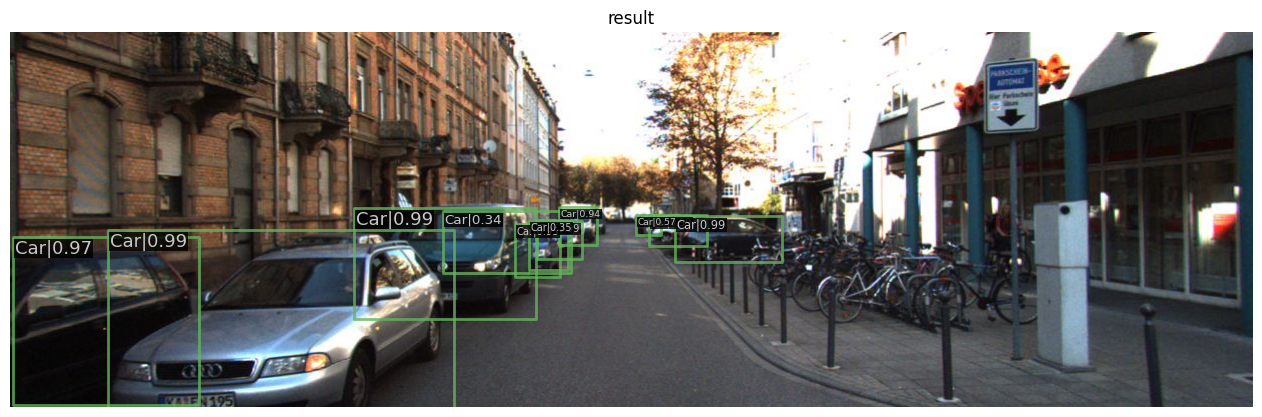

In [ ]:
# from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')
# model.cfg = cfg

# result = inference_detector(model, img)
# show_result_pyplot(model, img, result)

In [ ]:
# CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')

# labels_to_names_seq = {i:k for i,k in enumerate(CLASSES)}
# labels_to_names_seq[1]

'Truck'

In [ ]:
# CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
# cat2label = {i:k for i, k in enumerate(CLASSES)}

# def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
#   # 인자로 들어온 image_array를 복사.
#   draw_img = img_array.copy()
#   bbox_color=(0, 255, 0)
#   text_color=(0, 0, 255)

#   # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.
#   # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list.
#   results = inference_detector(model, img_array)

#   # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
#   # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
#   # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐.
#   for result_ind, result in enumerate(results):
#     # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행.
#     if len(result) == 0:
#       continue

#     # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외.
#     result_filtered = result[np.where(result[:, 4] > score_threshold)]

#     # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출.
#     for i in range(len(result_filtered)):
#       # 좌상단, 우하단 좌표 추출.
#       left = int(result_filtered[i, 0])
#       top = int(result_filtered[i, 1])
#       right = int(result_filtered[i, 2])
#       bottom = int(result_filtered[i, 3])
#       caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
#       cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
#       cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
#       if is_print:
#         print(caption)

#   return draw_img


In [ ]:
# import time

# def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):

#     cap = cv2.VideoCapture(input_path)

#     codec = cv2.VideoWriter_fourcc(*'XVID')

#     vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
#     vid_fps = cap.get(cv2.CAP_PROP_FPS)

#     vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

#     frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     print('총 Frame 갯수:', frame_cnt)
#     btime = time.time()
#     while True:
#         hasFrame, img_frame = cap.read()
#         if not hasFrame:
#             print('더 이상 처리할 frame이 없습니다.')
#             break
#         stime = time.time()
#         img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold, is_print=False)
#         if do_print:
#           print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
#         vid_writer.write(img_frame)
#     # end of while loop

#     vid_writer.release()
#     cap.release()

#     print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [ ]:
# do_detected_video(model, '/content/data/the_rock_chase.mp4', '/content/data/the_rock_chase_out1.mp4', score_threshold=0.4, do_print=True)

총 Frame 갯수: 503
frame별 detection 수행 시간: 0.1622
frame별 detection 수행 시간: 0.1494
frame별 detection 수행 시간: 0.1093
frame별 detection 수행 시간: 0.1149
frame별 detection 수행 시간: 0.1242
frame별 detection 수행 시간: 0.1085
frame별 detection 수행 시간: 0.1162
frame별 detection 수행 시간: 0.1141
frame별 detection 수행 시간: 0.1132
frame별 detection 수행 시간: 0.1122
frame별 detection 수행 시간: 0.1194
frame별 detection 수행 시간: 0.1134
frame별 detection 수행 시간: 0.1212
frame별 detection 수행 시간: 0.112
frame별 detection 수행 시간: 0.1217
frame별 detection 수행 시간: 0.1159
frame별 detection 수행 시간: 0.1225
frame별 detection 수행 시간: 0.1193
frame별 detection 수행 시간: 0.1143
frame별 detection 수행 시간: 0.1073
frame별 detection 수행 시간: 0.1047
frame별 detection 수행 시간: 0.1085
frame별 detection 수행 시간: 0.1042
frame별 detection 수행 시간: 0.1061
frame별 detection 수행 시간: 0.1079
frame별 detection 수행 시간: 0.1058
frame별 detection 수행 시간: 0.1039
frame별 detection 수행 시간: 0.1052
frame별 detection 수행 시간: 0.1057
frame별 detection 수행 시간: 0.106
frame별 detection 수행 시간: 0.1049
frame별 detection 수행 시간: 0